In [8]:
from brian2 import *
%matplotlib inline


In [9]:
def input_generate():
    pass

In [10]:
# Integrate and Fire Model
taum = 10*ms
Ee = 0*mV
vt = -54*mV
vr = -60*mV
El = -74*mV
taue = 5*ms
F = 15*Hz

IF_eqs = '''
dv/dt = (ge * (Ee-v) + El - v) / taum : volt
dge/dt = -ge / taue : 1
'''

[] V


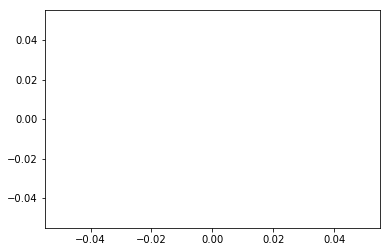

In [11]:
start_scope()
# Visual Input
visual_input_indices = array([0,1,0,1,1,0,
                       0,1,0,1,1,0])
visual_input_times = array([ 500,  550, 1000, 1010, 1500, 1510,
                     3500, 3550, 4000, 4010, 4500, 4510])*ms
visual_input = SpikeGeneratorGroup(2,visual_input_indices,visual_input_times)

# Visual neurons
visual_neurons = NeuronGroup(2,IF_eqs,threshold='v>vt',reset='v=vr',method='euler')
visual_neurons.v = vr

visual_spike_monitor = SpikeMonitor(visual_neurons)
visual_state_monitor = StateMonitor(visual_neurons, 'v', record=[0,1])

# Synapse between Input and Visual Neurons
visual_input_synapse = Synapses(visual_input,visual_neurons,model='''s:volt''',on_pre='v += s')
    # Connect neuron 0->0, 1->1
visual_input_synapse.connect(i = [0,1],j = [0,1])
visual_input_synapse.s = 100. *mV

visual_input_synapse_monitor = StateMonitor(visual_input_synapse,['s'],record = [0])
# Run the visual input
#run(6*second)
print(visual_state_monitor.v)
plot(visual_state_monitor.t,visual_state_monitor.v[0])
plot(visual_state_monitor.t,visual_state_monitor.v[1])

[] V
[] V


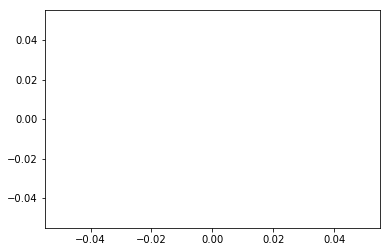

In [12]:
start_scope()
# Proprioceptive input
proprio_input_indices = array([0,1,0,1,1,0,
                       0,1,0,1,1,0])
proprio_input_times = array([ 500,  550, 1000, 1010, 1500, 1510,
                     3500, 3550, 4000, 4010, 4500, 4510])*ms
proprio_input = SpikeGeneratorGroup(2,proprio_input_indices,proprio_input_times)

# Proprioceptive neurons
proprio_neurons = NeuronGroup(2,IF_eqs,threshold='v>vt',reset='v=vr',method='euler')
proprio_neurons.v = vr

proprio_spike_monitor = SpikeMonitor(proprio_neurons)
proprio_state_monitor = StateMonitor(proprio_neurons, 'v', record=[0,1])

# Synapse between Input and Proprioceptive Neurons
proprio_input_synapse = Synapses(proprio_input,proprio_neurons,model='''s:volt''',on_pre='v += s')
    # Connect neuron 0->0, 1->1
proprio_input_synapse.connect(i = [0,1],j = [0,1])
proprio_input_synapse.s = 100. *mV

proprio_input_synapse_monitor = StateMonitor(proprio_input_synapse,['s'],record = [0])
# Run the proprioceptive input
#run(6*second)
print(proprio_state_monitor.v)
plot(proprio_state_monitor.t,proprio_state_monitor.v[0])
plot(proprio_state_monitor.t,proprio_state_monitor.v[1])

print(proprio_input_synapse_monitor.s)
#plot(proprio_input_synapse_monitor.t,proprio_input_synapse_monitor.s[0])

In [13]:
# STDP Synapse
taupre = taupost = 20*ms
gmax = 0.01
dApre = 0.01
dApost = -dApre * taupre / taupost * 1.05
dApost *= gmax
dApre *= gmax
'''
wmax = 0.01
Apre = 0.01
Apost = -Apre*taupre/taupost*1.05
'''
stdp_eqs = ''' w : 1
             dApre/dt = -Apre/taupre : 1 (event-driven)
             dApost/dt = -Apost/taupost : 1 (event-driven)
             '''
stdp_pre_eqs = '''ge+=w
             Apre += dApre
             w = clip(w+Apost, 0, gmax)
             '''
stdp_post_eqs='''Apost += dApost
             w = clip(w+Apre, 0, gmax)
             '''

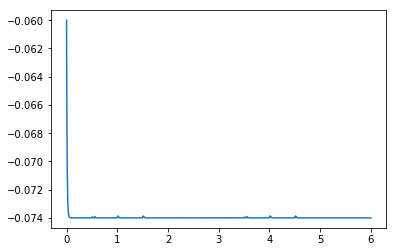

In [14]:
# VP integration neurons
vp_integrate_neurons = NeuronGroup(2,IF_eqs,threshold='v>vt',reset='v=vr',method='euler')
vp_integrate_neurons.v = vr

vp_integrate_spike_monitor = SpikeMonitor(vp_integrate_neurons)
vp_integrate_state_monitor = StateMonitor(vp_integrate_neurons, 'v', record=[0,1])

# STDP synapse
v_in_stdp_synapse = Synapses(visual_neurons,vp_integrate_neurons,
                             stdp_eqs,
                             on_pre=stdp_pre_eqs,
                             on_post=stdp_post_eqs,
                             method=euler)
v_in_stdp_synapse.connect(i=[0,0,1,1],j=[0,1,0,1])
v_in_stdp_synapse.w = 'rand()*gmax'
net = Network(visual_input,visual_neurons,visual_input_synapse,vp_integrate_neurons,v_in_stdp_synapse,vp_integrate_state_monitor)
net.run(6*second)

#plot(visual_state_monitor.t,visual_state_monitor.v[0])
#plot(visual_state_monitor.t,visual_state_monitor.v[1])
#print(visual_state_monitor.v[0])
plot(vp_integrate_state_monitor.t,vp_integrate_state_monitor.v[0])
